In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_pil_image
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5) )])

train_data = datasets.STL10('./data',  download = True, split = 'train', transform = transform)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

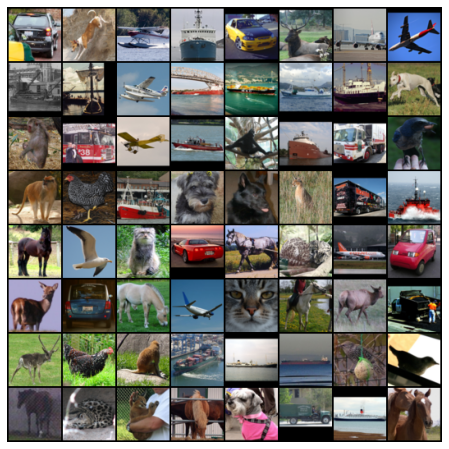

In [ ]:
batch = iter(train_loader).next()
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(make_grid(batch[0], normalize = True).permute(1,2,0))

In [ ]:
img, label = iter(train_loader).next()
print(img.shape, label.shape)

torch.Size([64, 3, 64, 64]) torch.Size([64])


In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, filters):
    super(Generator, self).__init__()

    self.noise = z_dim
    self.channels_img = channels_img
    self.main = nn.Sequential(
        
    nn.ConvTranspose2d(self.noise, filters * 8, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(filters * 8),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters * 8, filters * 4, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(filters * 4),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters * 4,filters * 2, kernel_size = 4,stride =2, padding = 1, bias = False),
    nn.BatchNorm2d(filters * 2),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters * 2, filters, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(filters),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters, self.channels_img, kernel_size = 4, stride = 2, padding =1, bias = False),
    nn.Tanh()   #마지막은 tanh 활성화함수를 활용해준다.

      )# CNN 5개를 쌓았다.
  def forward(self, x):
    
    return self.main(x)

In [ ]:
x = torch.rand(1,100,1,1, device = device)
generator = Generator(100, 3, 64).to(device)
x = generator(x)
print(x.shape)

torch.Size([1, 3, 64, 64])


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, img_channels, features):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        
    nn.Conv2d(img_channels, features, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(features, features * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(features * 2),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(features * 2, features * 4, kernel_size = 4,stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(features * 4),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(features * 4, features * 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(features * 8),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(features * 8, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.Sigmoid()

    )
  def forward(self, x):
    return self.main(x).view(-1,1)

In [ ]:
x = torch.rand(16, 3, 64, 64).to(device)
discriminator = Discriminator(3, 64).to(device)
x = discriminator(x)
print(x.shape)

torch.Size([16, 1])


In [ ]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') == 0:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') == 0:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
generator = nn.DataParallel(generator, list(range(1)))
generator.apply(initialize_weights)

In [ ]:
discriminator = nn.DataParallel(discriminator, list(range(1)))
discriminator.apply(initialize_weights)

In [ ]:
loss_func = nn.BCELoss()

lr = 2e-4
beta1 = 0.5
beta2 = 0.9

optim_gen = optim.Adam(generator.parameters(), lr  = lr, betas = (beta1, beta2))
optim_dis = optim.Adam(discriminator.parameters(), lr  = lr, betas = (beta1, beta2))

In [ ]:
generator.train()
discriminator.train()
noise = 100

epochs = 100
start_time = time.time()

loss_generator = []
loss_discriminator = []

for epoch in range(epochs):
  for img, label in train_loader:

    batch_size = img.shape[0]
    img = img.to(device)
    label_real = torch.ones(batch_size, 1).to(device)
    label_fake = torch.zeros(batch_size,1).to(device)

    generator.zero_grad()
    
    z = torch.rand(batch_size, noise, 1, 1).to(device)
    fake_img = generator(z) #가짜 이미지생성
    out_dis = discriminator(fake_img) #가짜 이미지 식별

    g_loss = loss_func(out_dis, label_real)
    g_loss.backward()
    optim_gen.step()

    discriminator.zero_grad()

    out_dis = discriminator(img) #진짜 이미지 식별
    loss_real = loss_func(out_dis, label_real)
    out_dis = discriminator(fake_img.detach()) #discriminator 훈련 중이므로 이미지에 대한 gradient 계산은 하지않는다.
    loss_fake = loss_func(out_dis, label_fake)

    d_loss = (loss_real + loss_fake) / 2
    d_loss.backward()
    optim_dis.step()

    loss_generator.append(g_loss.item())
    loss_discriminator.append(d_loss.item())

  print('Epoch : {}, G_Loss : {:.3f}, D_Loss : {:.3f}, Time = {}'.format(epoch+1, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))


Epoch : 1, G_Loss : 0.000, D_Loss : 4.273, Time = 0.18480345010757446
Epoch : 2, G_Loss : 2.682, D_Loss : 0.301, Time = 0.3476526935895284
Epoch : 3, G_Loss : 4.721, D_Loss : 0.775, Time = 0.5197405616442362
Epoch : 4, G_Loss : 2.599, D_Loss : 0.067, Time = 0.6797272086143493
Epoch : 5, G_Loss : 4.971, D_Loss : 0.017, Time = 0.8399783452351888
Epoch : 6, G_Loss : 3.482, D_Loss : 0.035, Time = 0.9998446742693583
Epoch : 7, G_Loss : 3.243, D_Loss : 0.069, Time = 1.1586482008298238
Epoch : 8, G_Loss : 3.003, D_Loss : 0.183, Time = 1.3181013266245525
Epoch : 9, G_Loss : 3.491, D_Loss : 0.234, Time = 1.4777012546857198
Epoch : 10, G_Loss : 2.835, D_Loss : 0.221, Time = 1.6437148173650107
Epoch : 11, G_Loss : 4.732, D_Loss : 0.184, Time = 1.8038049538930256
Epoch : 12, G_Loss : 3.930, D_Loss : 0.171, Time = 1.9645034869511921
Epoch : 13, G_Loss : 10.315, D_Loss : 0.197, Time = 2.124648614724477
Epoch : 14, G_Loss : 4.318, D_Loss : 0.124, Time = 2.284677505493164
Epoch : 15, G_Loss : 2.324, D

In [ ]:
g_loss

tensor(0.9891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

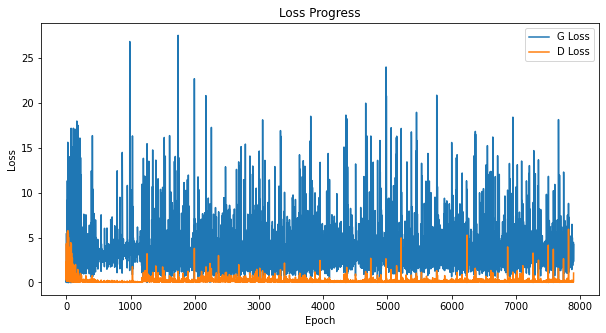

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_generator, label='G Loss')
plt.plot(loss_discriminator, label='D Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    fixed_noise = torch.randn(16, 100,1,1, device=device)
    img_fake = generator(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 3, 64, 64])


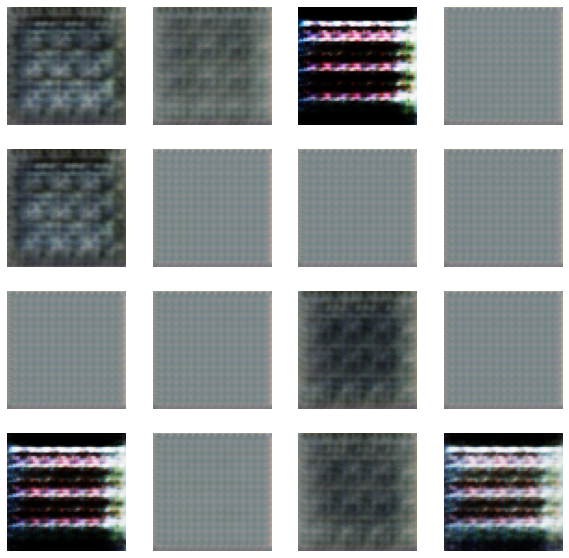

In [ ]:
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5))
    plt.axis('off')